In [1]:
"""
Instead of using a Functional API, we can create a model using a Subcalssing API. 

There are advantages and disadvantages associated with each method and it depends on the MLops and your model development strategies.

We are going to create a simple classifier using the iris dataset.

"""

'\nInstead of using a Functional API, we can create a model using a Subcalssing API. \n\nThere are advantages and disadvantages associated with each method and it depends on the MLops and your model development strategies.\n\nWe are going to create a simple classifier using the iris dataset.\n\n'

In [2]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout

from sklearn.metrics import classification_report,confusion_matrix,r2_score,mean_squared_error,mean_absolute_error

In [3]:
#Helper functions
def class_model_eval(history,epochs):

  """
  A classification model evaluation using history and epoch parameters

  #Arguments 
    history (keras obj) - keras history object
    epochs  (keras obj) - keras epcohs object
  #Returns
    training an dvalidation plots for classification analysis
  """
  #NOTE due to train and validation set calculation specifics epochs need to be shifted
  plt.plot(range(len(epochs)),history['loss'],'b-',label="Train loss")
  plt.plot(range(len(epochs)),history['val_loss'],'r-',label="Validation loss")
  plt.legend()
  plt.show()

  plt.plot(range(len(epochs)),history['accuracy'],'b-',label="Train accuracy")
  plt.plot(range(len(epochs)),history['val_accuracy'],'r-',label="Validation accuracy")
  plt.legend()
  plt.show()
  return

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


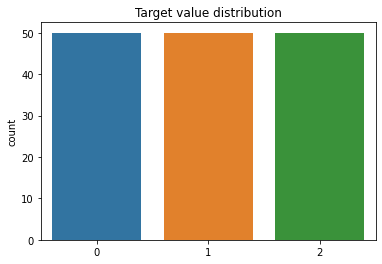

       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)      target  
count        150.000000  150.000000  
mean           1.199333    1.000000  
std            0.762238    0.819232  
min            0.100000    0.000000  
25%            0.300000    0.000000  
50%            1.300000    1.000000  
75%            1.800000    2.000000  
max            2.500000    2.000000   

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width

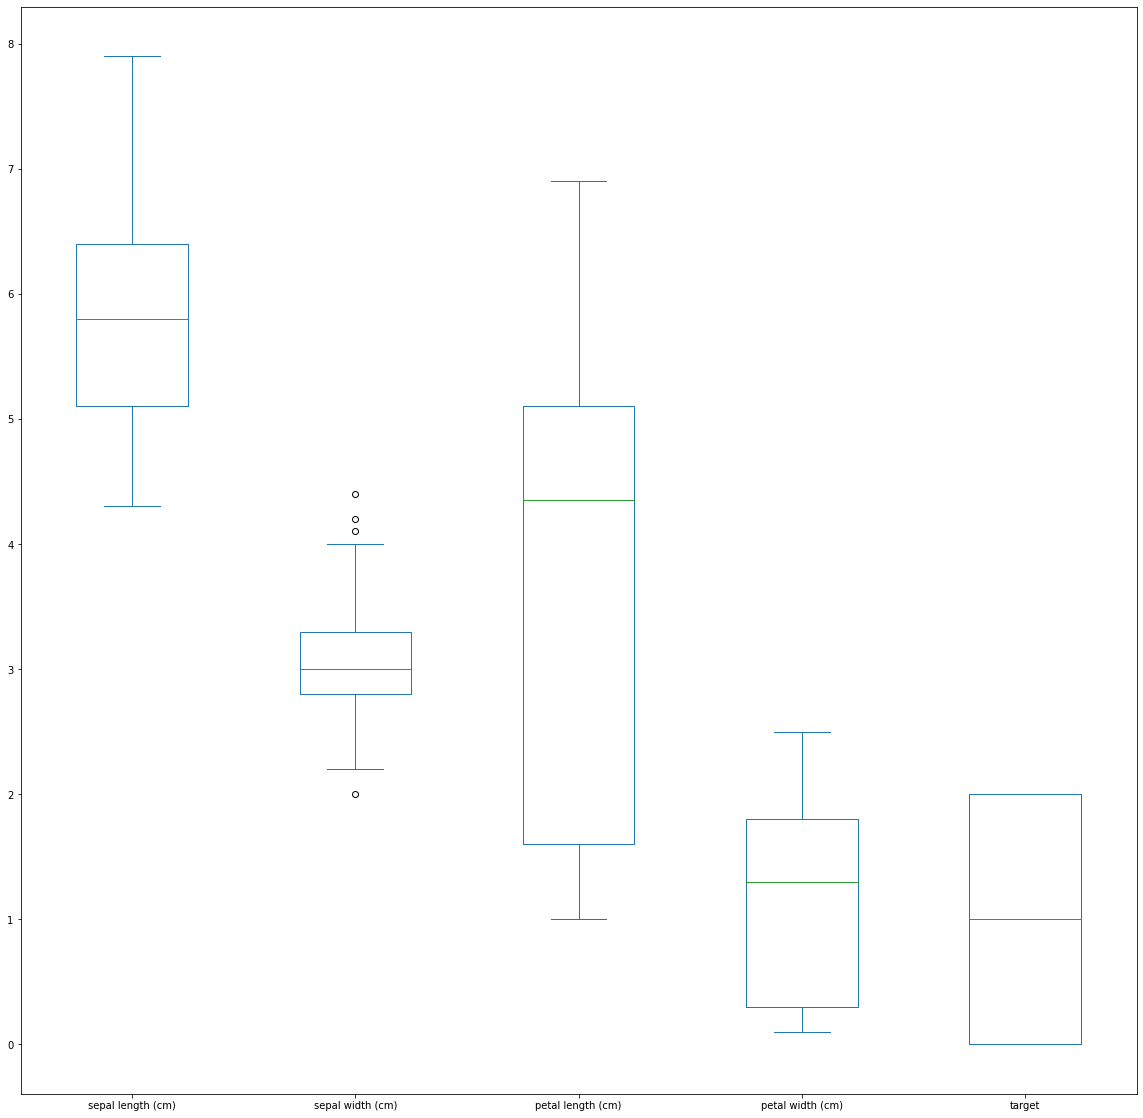

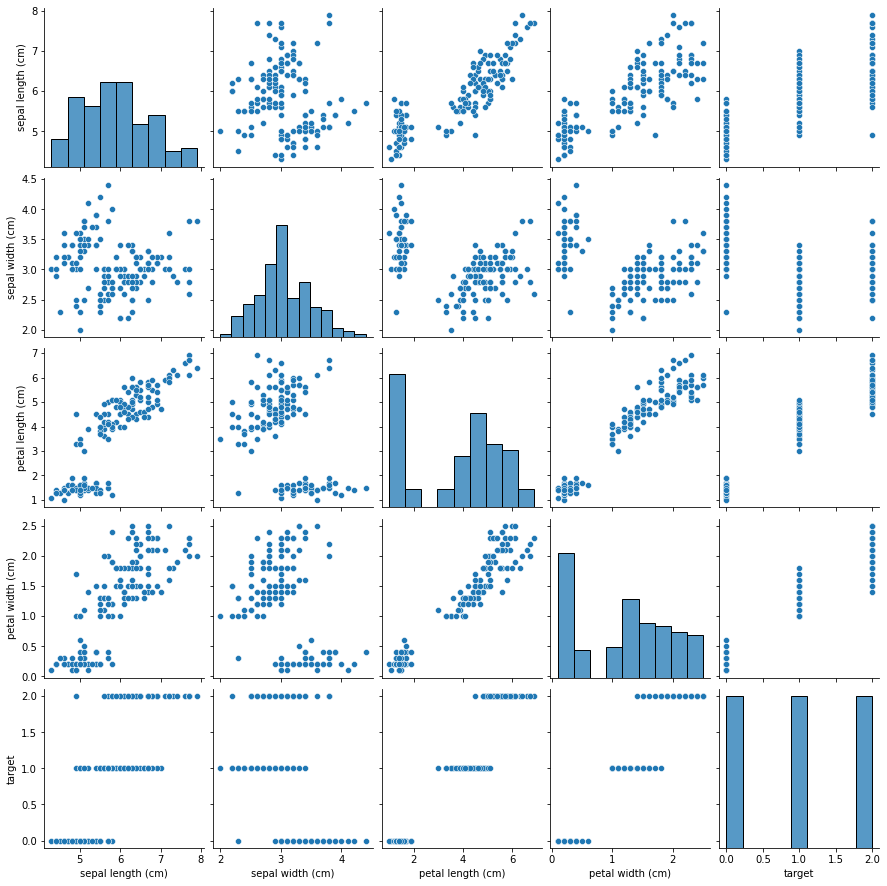

In [4]:


#Load data

data_iris=load_iris()

data=pd.DataFrame(data=data_iris.data,columns=data_iris.feature_names)
target=data_iris.target

#Check the data (high level overview)
#NOTE you should build a separate custom set of functions for data integrity checks and EDA

sns.countplot(target)
plt.title("Target value distribution")
plt.show()

df=data.copy()
df['target']=target
print(df.describe(),"\n")

print(data.head(),"\n")

df.plot.box(figsize=(20,20))
plt.show()

sns.pairplot(df,diag_kind='hist')
plt.show()

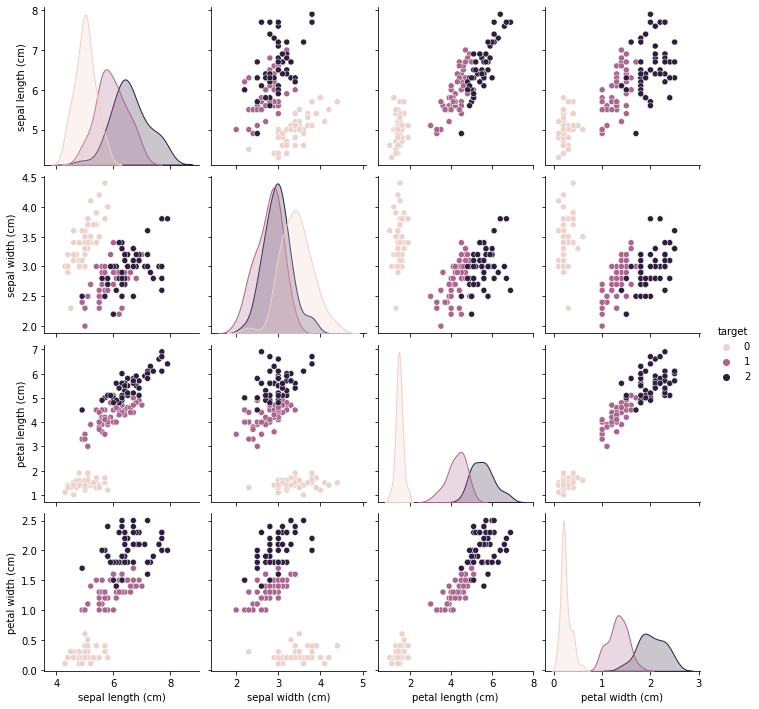

In [ ]:
#Use pairplots to quickly evaluate any dependencies or cutoffs in the data
df=data.copy()
df['target']=target
sns.pairplot(df,diag_kind='kde',hue='target')
plt.show()

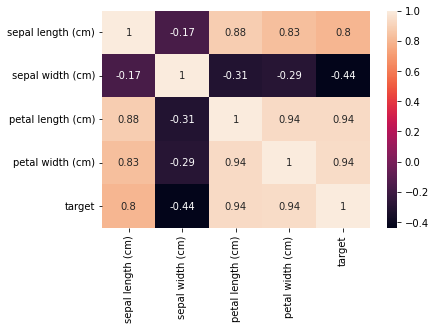

In [ ]:
#Check for value correlation
sns.heatmap(df.corr(method='spearman'),annot=True)
plt.show()

In [5]:
#Prepare data for modelling

#Split data

X_train,X_test,y_train,y_test=train_test_split(data,target,test_size=0.2,random_state=0)

#Scale data
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [6]:
#Set params

EPOCHS=500
BATCH=10
VAL_SPLIT=0.2
NUM_CLASSES=3
INPUT_SHAPE=X_train.shape[1:]
callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)


In [7]:
#Create a baseline classification model

def class_base_model(num_classes,units=10,input_shape=INPUT_SHAPE):
  """
  A simple model builder to establish a baseline classification 
  #NOTE several baseline models can be used to better assess target model performance
  
  #Arguments
  units, int - dense layer units
  input_shape, tuple(int) - input shape (None, Features)
  num_classes, int - number of classes, default is 1 (which will generate an error)
  #Returns
  model (keras obj)
  """
  model=Sequential()

  model.add(Dense(units,activation='relu',input_shape=input_shape))
 

  if num_classes>=3:
    model.add(Dense(num_classes,activation='softmax'))
  else:
    model.add(Dense(1,activation='sigmoid'))
  model.summary()

  if num_classes>=3:
    model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])
  else:
    model.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])

  return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 83
Trainable params: 83
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
10/10 [==============================] - 3s 23ms/step - loss: 1.2609 - accuracy: 0.1458 - val_loss: 1.3006 - val_accuracy: 0.0833
Epoch 2/500
10/10 [==============================] - 0s 5ms/step - loss: 1.1882 - accuracy: 0.2708 - val_loss: 1.2413 - val_accuracy: 0.1667
Epoch 3/500
10/10 [==============================] - 0s 5ms/step - loss: 1.1235 - accuracy: 0.3125 - val_loss: 1.1864 - val_accuracy: 0.2083
Epoch 4/500
10/10 [=============

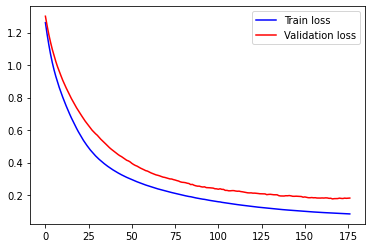

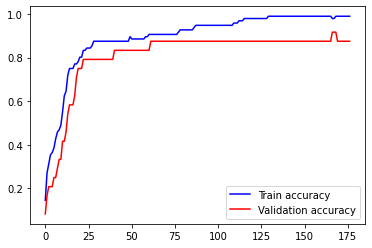

In [8]:
#Fit base model for classifier
base_model_class=class_base_model(NUM_CLASSES)
history=base_model_class.fit(X_train,y_train,batch_size=BATCH,epochs=EPOCHS,validation_split=VAL_SPLIT,callbacks=[callbacks])

epochs=history.epoch
history=history.history
BEST_EPOCH=np.argmin(history['val_loss'])
print("Best epoch", np.argmin(history['val_loss']))


class_model_eval(history,epochs)

#NOTE models can be saved

In [88]:
#Define wide and deep model as a class object using keras.Model

class GetModel(tf.keras.Model):

  def __init__(self, units=32,dropout=0.2,num_classes=NUM_CLASSES,activation='relu'):

    super().__init__()
    #Define hidden layers
    self.h1=tf.keras.layers.Dense(units*3,activation=activation,name="h1")
    self.h2=tf.keras.layers.Dense(units*2,activation=activation,name="h2")
    self.h3=tf.keras.layers.Dense(units,activation=activation,name="h3")

    if units>=32:
      self.h4=tf.keras.layers.Dense(units//2,activation=activation,name="h4")
    else:
      self.h4=None

    #Define dropout 
    self.d=tf.keras.layers.Dropout(dropout,name="dropout")

    #Define outputs
    self.mainOut=tf.keras.layers.Dense(num_classes,activation='softmax',name="main_output")
    self.auxOut=tf.keras.layers.Dense(num_classes,activation='softmax',name="aux_output")

  def call(self,inputs):
    
    input_A=inputs[0] #wide 
    input_B=inputs[1] #deep

    #Construct deep layers
    h1=self.h1(input_B)
    h1_d1=self.d(h1)

    h2=self.h2(h1_d1)
    h2_d2=self.d(h2)

    h3=self.h3(h2_d2)
    h3_d3=self.d(h3)

    if self.h4 is not None:
      h4=self.h4(h3_d3)
      h4_d4=self.d(h4)

      concat=keras.layers.concatenate([input_A,h4_d4])
      main_output=self.mainOut(concat)
      aux_output=self.auxOut(h4_d4) #we only assess deep model for aux output

    else:

      concat=keras.layers.concatenate([input_A,h3_d3])
      main_output=self.mainOut(concat)
      aux_output=self.auxOut(h3_d3) #we only assess deep model for aux output

    return main_output, aux_output


In [89]:
#Create the model
input_shape_A=keras.Input(shape=X_train.shape[1:],name="wide")
input_shape_B=keras.Input(shape=X_train.shape[1:],name="deep")


outputs=GetModel()([input_shape_A,input_shape_B])

model=tf.keras.Model(inputs=[input_shape_A,input_shape_B],outputs=[outputs[0],outputs[1]],name="Class_model")

print(model.summary())


Model: "Class_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 wide (InputLayer)              [(None, 4)]          0           []                               
                                                                                                  
 deep (InputLayer)              [(None, 4)]          0           []                               
                                                                                                  
 get_model (GetModel)           ((None, 3),          9410        ['wide[0][0]',                   
                                 (None, 3))                       'deep[0][0]']                   
                                                                                                  
Total params: 9,410
Trainable params: 9,410
Non-trainable params: 0
____________________

In [91]:
#Compile the model
model.compile(loss=["sparse_categorical_crossentropy",'sparse_categorical_crossentropy'],loss_weights=[0.4,0.6],optimizer='adam',
              metrics=['accuracy'])

In [92]:
history=model.fit([X_train,X_train],[y_train,y_train],batch_size=BATCH,epochs=EPOCHS,validation_split=VAL_SPLIT)

epochs=history.epoch
history=history.history
BEST_EPOCH=np.argmin(history['val_loss'])
print("Best epoch", np.argmin(history['val_loss']))

Epoch 1/500
10/10 [==============================] - 57s 33ms/step - loss: 1.2926 - get_model_loss: 1.5779 - get_model_1_loss: 1.1024 - get_model_accuracy: 0.0625 - get_model_1_accuracy: 0.3125 - val_loss: 1.1912 - val_get_model_loss: 1.3774 - val_get_model_1_loss: 1.0671 - val_get_model_accuracy: 0.1250 - val_get_model_1_accuracy: 0.5833
Epoch 2/500
10/10 [==============================] - 0s 9ms/step - loss: 1.2193 - get_model_loss: 1.4871 - get_model_1_loss: 1.0408 - get_model_accuracy: 0.1042 - get_model_1_accuracy: 0.5312 - val_loss: 1.1209 - val_get_model_loss: 1.2877 - val_get_model_1_loss: 1.0097 - val_get_model_accuracy: 0.2083 - val_get_model_1_accuracy: 0.5417
Epoch 3/500
10/10 [==============================] - 0s 7ms/step - loss: 1.1069 - get_model_loss: 1.3271 - get_model_1_loss: 0.9601 - get_model_accuracy: 0.1771 - get_model_1_accuracy: 0.6146 - val_loss: 1.0074 - val_get_model_loss: 1.1573 - val_get_model_1_loss: 0.9075 - val_get_model_accuracy: 0.2500 - val_get_model_

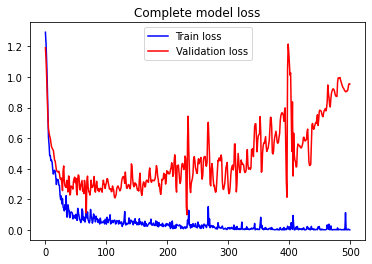

In [95]:
#Evaluate combined loss values where loss_weights are weighed based on the values provided earlier

plt.plot(epochs,history['loss'],'b-',label="Train loss")
plt.plot(epochs,history['val_loss'],'r-',label="Validation loss")
plt.legend()
plt.title("Complete model loss")
plt.show()

In [96]:
history.keys()

dict_keys(['loss', 'get_model_loss', 'get_model_1_loss', 'get_model_accuracy', 'get_model_1_accuracy', 'val_loss', 'val_get_model_loss', 'val_get_model_1_loss', 'val_get_model_accuracy', 'val_get_model_1_accuracy'])

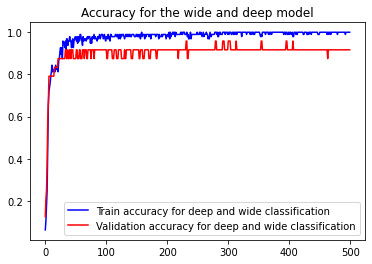

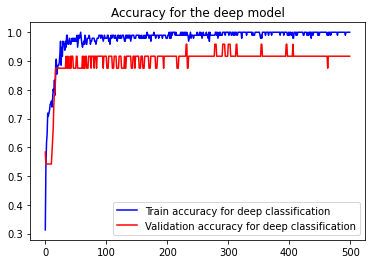

In [97]:
#Classification


plt.plot(epochs,history["get_model_accuracy"],'b-',label="Train accuracy for deep and wide classification")
plt.plot(epochs,history['val_get_model_accuracy'],'r-',label="Validation accuracy for deep and wide classification")
plt.legend()
plt.title("Accuracy for the wide and deep model")
plt.show()

plt.plot(epochs,history['get_model_1_accuracy'],'b-',label="Train accuracy for deep classification")
plt.plot(epochs,history['val_get_model_1_accuracy'],'r-',label="Validation accuracy for deep classification")
plt.legend()
plt.title("Accuracy for the deep model")
plt.show()

In [98]:
#Evaluate functional model
model.evaluate([X_train,X_train],[y_train,y_train])

y_pred,y_pred_class_deep=model.predict([X_test,X_test])

4/4 [==============================] - 0s 4ms/step - loss: 0.1909 - get_model_loss: 0.1969 - get_model_1_loss: 0.1869 - get_model_accuracy: 0.9833 - get_model_1_accuracy: 0.9833        


In [99]:
print("Classification model evaluation for a combined wide and deep model\n",classification_report(y_test,np.argmax(y_pred,axis=1)),"\n")

print("Classification model evaluation for a deep model\n",classification_report(y_test,np.argmax(y_pred,axis=1)),"\n")

Classification model evaluation for a combined wide and deep model
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.93      1.00      0.96        13
           2       1.00      0.83      0.91         6

    accuracy                           0.97        30
   macro avg       0.98      0.94      0.96        30
weighted avg       0.97      0.97      0.97        30
 

Classification model evaluation for a deep model
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.93      1.00      0.96        13
           2       1.00      0.83      0.91         6

    accuracy                           0.97        30
   macro avg       0.98      0.94      0.96        30
weighted avg       0.97      0.97      0.97        30
 



This example provides a quick overview of how subclassing works. Subclassing helps with model architecture development and inspecting various behaviors. For example, we could that the model begins to overfit.